# Group Project
### Authors: Zhiyi Chen, Qiaona Wan, Tony Jianqi Yu, Yunong Zhang, Victoria Zhao

## Data Description

The dataset was retrieved from Kaggle, and this data contains several predictors including the number of steps in making the transaction, the amount of money being transferred, the type of transaction, etc, and these variables are used to predict whether the transaction is a fraud. Our goal is to find which variables are significant in detecting a fraud transaction, and we are interested in whether a fraud transaction can be predicted using machine learning models.

The target variable used in the following models will be "isFraud", which is a binary categorical variable with 0 as no Fraud and 1 as Fraud. The explanatory variables used in the models will be "step", "type", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "isFlaggedFraud", and varianles "type" and "isFlaggedFraud" are categorical variables, while the rest are numeric variables.

"oldbalanceOrg" and "newbalanceOrig" are the senders' balances before and after a transaction, and "oldbalanceDest" and "newbalanceDest" are the receivers' balances before and after a transaction. "step" is the number of steps/procedures before the transaction is made. "amount" is the amount of money is involved in the transaction. "type" is the method used to make the transaction, and it has 5 different categories. The categories will be encoded to numbers for the modeling process. "isFlaggedFraud" is a binary categorical variable, meaning whether the transaction has been flagged as fraud, but a flagged fraud transaction does not mean the transaction is a fraud and vice versa.

The data is imbalanced as there are less fraud transactions contained in the dataset, which is great, but it is also bad for modeling. Therefore, the SMOTE method will be used to deal with these imbalanced data.

In [1]:
from random import sample
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("Online-payment-fraud-detection.csv")
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


The nameOrig is the unique id of the client who initiated the transaction, and it has 633307 different values.<br>
The transaction's receiver, nameDest, has 2722362 distinct values.<br>
These two variables are left out of the model since they don't assist predict the target value.<br>

In [3]:
#drop variables
data.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

In [4]:
#encode transaction types to numeric numbers
data["type"].value_counts()
encode_type = {"type":     {"PAYMENT": 1, "TRANSFER": 2, "CASH_OUT": 3, "CASH_IN":4, "DEBIT":5}}
data = data.replace(encode_type)

In [5]:
#See how imbalanced it is 
data["isFraud"].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [29]:
#Imbalanced Data, use SMOTE
#take 10000 sample
data=data.sample(n=10000, random_state = 123)
from imblearn.over_sampling import SMOTE
X = data.drop('isFraud', axis=1).values
y = data['isFraud'].values
#pip install -U imbalanced-learn
smote = SMOTE(k_neighbors=10, random_state=42)
X, y = smote.fit_resample(X, y)

In [7]:
#set train, test data
from sklearn.model_selection import train_test_split
np.random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 1 Logistic Regression

Our target variable "is_Fraud" is a binary categorical variable, with 0 being not a fraud and 1 being a fraud, so we will first use the logistic regression with grid search and monte-carlo cross-validation method to see how the data is fitted

In [18]:
#Naive forecast
print(y.sum()/len(y))

0.5


In [19]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
#set up parameters
nmc = 250
testSize = 0.25
#make pipeline and setup standard scaler to scale the data
fullModel = make_pipeline(StandardScaler(),LogisticRegression())
param_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
param_grid={'logisticregression__C': param_list,'logisticregression__max_iter':[10000]}
#shuffle and fit grid search
shuffle = ShuffleSplit(test_size=testSize,n_splits=nmc)
grid_search=GridSearchCV(fullModel, param_grid, cv=shuffle, return_train_score = True, n_jobs=-1)
grid_search.fit(X,y)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
print(results[['rank_test_score','mean_test_score','param_logisticregression__C']])

# Print best params and model
print("best param:",grid_search.best_params_)
print("best model:",grid_search.best_estimator_)
print("best test score:",grid_search.best_score_)

# get the best model with hyperparameters
best_model = grid_search.best_estimator_

# Rerun cross validation for this best model
CVInfo = cross_validate(best_model, X, y, cv=shuffle,return_train_score=True,n_jobs=-1)

print(np.mean(CVInfo['train_score']))
print(np.mean(CVInfo['test_score']))

   rank_test_score  mean_test_score param_logisticregression__C
0                8         0.851646                     0.00001
1                7         0.859029                      0.0001
2                6         0.872108                       0.001
3                5         0.893551                        0.01
4                4         0.943064                         0.1
5                3         0.961511                           1
6                2         0.973333                          10
7                1         0.982066                         100
best param: {'logisticregression__C': 100, 'logisticregression__max_iter': 10000}
best model: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=100, max_iter=10000))])
best test score: 0.9820664797757308
0.982049132176235
0.9819295154185022


The naïve forecast's accuracy is 0.5 since the data has been balanced using the SOMTE method. In terms of accuracy, our logistic regression produced excellent results.

## 2 Random Forest

We utilized Random Forest to train the model and feature importances function to see how important each feature is. We were looping across 300 trees to find the number of trees with the best accuracy.

Random forest is a machine learning technique developed by Leo Breiman and Adele Cutler that mixes the output of numerous decision trees to produce a single outcome. The  popularity of random forest model is due to its ease of use and flexibility, as it can handle both classification and regression problems.

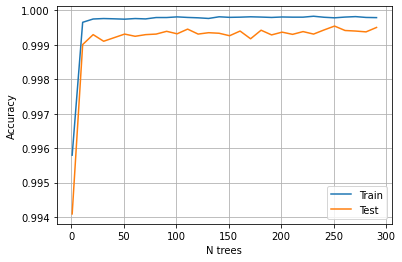

In [20]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
max_estimators = 300
scoreTrainList = []
scoreTestList  = []
scoreTestx = []

for i in range(1,max_estimators,10):
    forest = RandomForestClassifier(max_depth=10,n_estimators=i)
    shuffle = ShuffleSplit(n_splits=25, test_size=.25)
    CVInfo = cross_validate(forest, X, y, cv=shuffle,return_train_score=True,n_jobs=-1)
    scoreTrainList.append(np.mean(CVInfo['train_score']))
    scoreTestList.append(np.mean(CVInfo['test_score']))
    scoreTestx.append(i)
    
plt.plot(scoreTestx,scoreTrainList,label="Train")
plt.plot(scoreTestx,scoreTestList,label="Test")
plt.xlabel("N trees")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

In [23]:
max_y = max(scoreTestList)  # Find the maximum y value
max_x = scoreTestx[scoreTestList.index(max_y)]  # Find the x value corresponding to the maximum y value
print (max_x, max_y)
print ('We will use ',max_x,'as the number of estimators.')

251 0.999543452142571
We will use  251 as the number of estimators.


In [24]:
forest = RandomForestClassifier(n_estimators=max_x,max_features=6,max_depth=10,random_state=1124)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.999


          feature  importance       std
7  isFlaggedFraud    0.000000  0.000000
5  oldbalanceDest    0.015730  0.019390
6  newbalanceDest    0.034001  0.039172
1            type    0.058564  0.069232
0            step    0.083750  0.074151
4  newbalanceOrig    0.092284  0.048249
3   oldbalanceOrg    0.270636  0.166803
2          amount    0.445037  0.165618


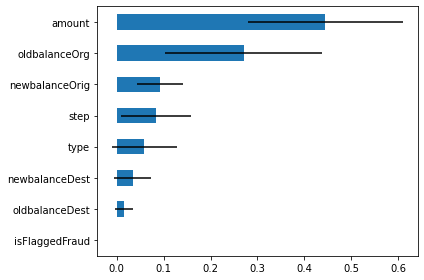

In [45]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

df = pd.DataFrame({'feature': X_train.columns, 'importance': importances, 'std': std})
df = df.sort_values('importance')
print(df)

ax = df.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')

plt.tight_layout()
plt.show()

We are able to see that according to random foreast, amount and old balance are the good indicators of a fraud activity.


## 3 Ensemble
We utilized Ensemble models. <br>

Ensemble models are a machine learning technique for predictions that combines various different models. 'Base estimators' are the names given to those models. It's a way to get over the technical difficulties in High variance: The model is extremely sensitive to the learnt features' inputs.<br>
you'll find Bootstrap and Bagging below.<br>

In [31]:
# Restate Initial data sample #Imbalanced Data, use SMOTE
#take 10000 sample
data=data.sample(n=10000, random_state = 123)
from imblearn.over_sampling import SMOTE
X = data.drop('isFraud', axis=1)
y = data['isFraud']
#pip install -U imbalanced-learn
smote = SMOTE(k_neighbors=10, random_state=42)
X, y = smote.fit_resample(X, y)

Build a model combination with voting:

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs",penalty='none',random_state=42,max_iter=10000)
dtc_clf = DecisionTreeClassifier(max_depth=10,random_state=42)
svm_clf =SVC(random_state=12,kernel="rbf")

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('dtc', dtc_clf), ('svc', svm_clf)],
    voting='hard')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=10000, penalty='none',
                                                 random_state=42)),
                             ('dtc',
                              DecisionTreeClassifier(max_depth=10,
                                                     random_state=42)),
                             ('svc', SVC(random_state=12))])

In [33]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, dtc_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.990738423028786
DecisionTreeClassifier 0.9984981226533166
SVC 0.9504380475594493
VotingClassifier 0.997747183979975


Bootstrap <br>
Bootstrapping is a resampling approach that includes pulling samples from our source data periodically with replacement, usually to estimate a population parameter. By "with replacement," we imply that the same data point may appear numerous times in our resampled dataset.

In [34]:
# Sample size
nsamp = 10000
# Number of bootstraps
nbootstraps = 1000
# Generate initial data sample
x = np.random.normal(size=nsamp,loc=0,scale=1)
# Space to store bootstrap means
mb = np.zeros(nbootstraps)
# Main bootstrap loop
for i in range(nbootstraps):
    # Draw a bootstrap sample from data with replacement
    xb = np.random.choice(x,size=nsamp,replace=True)
    mb[i]=np.mean(xb)
print(np.mean(mb))
print(np.std(mb))
# Theoretical standard deviation
print(1./np.sqrt(nsamp))

-0.002723107697794325
0.00981528967326768
0.01


Bagging Predictors<br>

Bagging is a bootstrapping-based technique for ensemble learning. To summarize, given a training set, we generate numerous alternative training sets (referred to as bootstrap samples) by sampling with replacements from the original dataset. Then we develop a model for each bootstrap sample. As a consequence, an ensemble of models is formed, with each model voting with equal weight. The purpose of this approach is often to lower the variance of the model of interest (decision trees).

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    random_state=42,test_size=0.25)

from sklearn.ensemble import BaggingClassifier
dtc_clf = DecisionTreeClassifier(max_depth=10)
bag_clf = BaggingClassifier(dtc_clf,n_estimators=100,bootstrap=True,max_samples=1.,random_state=40)
bag_clf.fit(X_train,y_train)
y_hat_train = bag_clf.predict(X_train)
y_hat = bag_clf.predict(X_test)
print(accuracy_score(y_hat_train,y_train))
print(accuracy_score(y_hat,y_test))

0.9993991989319092
0.9987985582699239


Out of Bag Estimate<br>
Out of Bag Estimate refers to cases that were not utilized during training. It is useful as a test estimate.

In [36]:
bag_clf = BaggingClassifier(dtc_clf, n_estimators=100,max_samples=150,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9879839786381842

Single Decision Tree

All of the tree-based models presented above are based on the decision tree model. A decision tree begins with a simple question, such as "Is it a fraud" You may then ask a series of questions to get a response, such as "What is the amount of the transaction?" or "What is the balance after the transaction?" These questions comprise the tree's decision nodes, which serve as a mechanism for dividing the data. Each inquiry assists a person in reaching a final choice, which is symbolized by the leaf node.

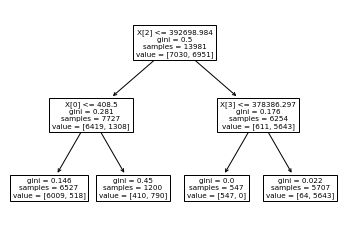

In [49]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)

clf = DecisionTreeClassifier(max_depth = 2, 
                             random_state = 0)

clf.fit(X_train, y_train)

plot_tree(clf);

## 4 KNN Classifier
The KNN model is a supervised machine learning technique that implies comparable items are nearby. In other words, comparable objects are close together.

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ShuffleSplit
def KNN(neighbor,X,y):
    neigh = KNeighborsClassifier(n_neighbors= neighbor)
    testSize = 0.5
    shuffle = ShuffleSplit(n_splits=25,test_size = 0.25)
    CVInfo = cross_validate(neigh,X,y,cv=shuffle,return_train_score = True)
    train_acc = np.mean(CVInfo['train_score'])##train
    test_acc = np.mean(CVInfo['test_score'])##test
    return train_acc,test_acc

In [53]:
train_ac_list = []
test_ac_list = []
for i in range(10,41):
    train_acc,test_acc = KNN(i,X,y)
    train_ac_list.append(train_acc)
    test_ac_list.append(test_acc)
range_list = np.arange(10,41,5)
#plt.plot(range_list,train_ac_list)
#plt.plot(range_list,test_ac_list)
nbest = np.argmax(test_ac_list)
best_neighbor = range_list[nbest]
print('the best neighbor is ',best_neighbor)

the best neighbor is  10


Accuracy

In [54]:
kneighbor = KNeighborsClassifier(n_neighbors=best_neighbor,n_jobs = -1)
kneighbor.fit(X_train,y_train)
print('the train accuracy is ', kneighbor.score(X_train,y_train))
print('the test accuracy is ', kneighbor.score(X_test,y_test))

the train accuracy is  0.9943494742865318
the test accuracy is  0.9929918237944269


## Summary 
In terms of accuracy, all of the models we tested performed admirably. All of these models' computational times are adequate, excluding the time spent on grid search for hyper-parameters. In terms of interpretability, the single decision tree is the best model.

The accuracy is high because the data is largely imbalanced, with less number of fraud transactions; therefore, the fraud transactions are easier to predict, and due to the high accuracy, machine learning models are frequently been used in order to detect the fraudulence in the bank.

In the future study, we would like to add more explanatory variables to the model and see if the accuracy would vary, and we also want to use different target variables to predict fraudulence, as the current target variable is heavily imbalanced, which would bias the prediction results.